In [1]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchjpeg import dct
# from scipy.fftpack import dct, idct
# import torch_dct as dct_2d, idct_2d
from PIL import Image
import os 
import numpy as np
import torch
import torchvision.transforms as T

block_size = 4
total_frequency_components = block_size * block_size
check_reconstruct_img = True
save_block_img_to_drive = False

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension 

def img_reorder(x, bs, ch, h, w):
    x = (x + 1) / 2 * 255
    assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
    x = dct.to_ycbcr(x)  # comvert RGB to YCBCR
    x -= 128
    x = x.view(bs * ch, 1, h, w)
    x = F.unfold(x, kernel_size=(block_size, block_size), dilation=1, padding=0, stride=(block_size, block_size))
    x = x.transpose(1, 2)
    x = x.view(bs, ch, -1, block_size, block_size)
    return x

## Image reordering and testing
def img_inverse_reroder(coverted_img, bs, ch, h, w):
    x = coverted_img.view(bs* ch, -1, total_frequency_components)
    x = x.transpose(1, 2)
    x = F.fold(x, output_size=(h, w), kernel_size=(block_size, block_size), stride=(block_size, block_size))
    x += 128
    x = x.view(bs, ch, h, w)
    x = dct.to_rgb(x)#.squeeze(0)
    x = (x / 255.0) * 2 - 1
    return x

## Image frequency cosine transform
def test_img_dct_transform_reorder_noise(x, bs, ch, h, w, freq_comp_lb):
    back_input = x
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_num = h // 4
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    
    for i in range(freq_comp_lb):
        dct_block_reorder[:, :, i, :, :] = dct_block_reorder[:, :, freq_comp_lb, :, :]
 
    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    print(torch.allclose(inverse_transformed_img, back_input, atol=1e-4))
    return inverse_transformed_img


## Image frequency cosine transform
def test_img_dct_transform(x, bs, ch, h, w):
    back_input = x
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_size = 4
    block_num = h // block_size
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
 
    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    print(torch.allclose(inverse_transformed_img, back_input, atol=1e-4))
    return inverse_transformed_img

## Image frequency cosine transform
def test_img_dct_transform_drop_high_freq_reorder(x, bs, ch, h, w, freq_comp_lb):
    back_input = x
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_size = 4
    block_num = h // block_size
    total_block_num = block_size * block_size
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    
    for i in range(freq_comp_lb, total_block_num, 1):
        dct_block_reorder[:, :, i, :, :] = dct_block_reorder[:, :, i, :, :].zero_()
        # dct_block_reorder[:, :, i, :, :] = torch.zeros_like(dct_block_reorder[:, :, i, :, :])
 
    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    print(torch.allclose(inverse_transformed_img, back_input, atol=1e-4))
    return inverse_transformed_img


## Image frequency cosine transform
def test_img_dct_transform_drop_low_freq_reorder(x, bs, ch, h, w, freq_comp_lb):
    back_input = x
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_size = 4
    block_num = h // block_size
    total_block_num = block_size * block_size
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    
    for i in range(0, freq_comp_lb, 1):
        dct_block_reorder[:, :, i, :, :] = dct_block_reorder[:, :, i, :, :].zero_()
 
    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    print(torch.allclose(inverse_transformed_img, back_input, atol=1e-4))
    return inverse_transformed_img

## Image frequency cosine transform
def test_img_dct_transform_duplicate_freq_reorder(x, bs, ch, h, w, freq_comp_lb):
    back_input = x
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_size = 4
    block_num = h // block_size
    total_block_num = block_size * block_size
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    
    for i in range(freq_comp_lb, total_block_num, 1):
        dct_block_reorder[:, :, i, :, :] = dct_block_reorder[:, :, freq_comp_lb, :, :]

    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    print(torch.allclose(inverse_transformed_img, back_input, atol=1e-4))
    return inverse_transformed_img


## Image frequency cosine transform
def test_img_dct_transform_reorder_noise_outsource(x, bs, ch, h, w, freq_comp_lb, path_variance_matrix_tensor, add_noise):
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_num = h // 4
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    
    for i in range(freq_comp_lb):
        dct_block_reorder[:, :, i, :, :] = dct_block_reorder[:, :, freq_comp_lb, :, :]
    if add_noise:
        mean = np.zeros(256)
        variance_matrix_tensor = torch.load(path_variance_matrix_tensor).cpu()
        total_sample_noises = dct_block_reorder.shape[0] * dct_block_reorder.shape[1] * dct_block_reorder.shape[2] * dct_block_reorder.shape[3]
        noise_sample = torch.from_numpy(np.random.multivariate_normal(mean, variance_matrix_tensor.detach().numpy(), total_sample_noises)).to(torch.float)
        noise_sample = noise_sample.reshape(dct_block_reorder.shape)
        dct_block_reorder = dct_block_reorder + noise_sample
    
    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    return inverse_transformed_img

<>:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1090270/2803628706.py:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")


# The following cells do not loaded data from data loader (the preprocessing is missing). So the conclusion might not directly applied to the scenario when outsourcing all components.

# Drop high frequency components

In [3]:
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(test_img_path)
overall_img_drop_high_freq_list = []
block_size = 4 
total_block_num = block_size * block_size
bs, ch, h, w = test_image_tensor.shape
base_freq_cutoff_list = [i for i in range(1, total_block_num+1, 1)]
for base_freq_cutoff in base_freq_cutoff_list:
    test_inverse_transformed_img = test_img_dct_transform_drop_high_freq_reorder(test_image_tensor, bs, ch, h, w, base_freq_cutoff)
    transforms.functional.to_pil_image(test_inverse_transformed_img.squeeze(0)).save(f'reconstruct_dct_idct_image_drop_high_freq_{base_freq_cutoff}.png')
    overall_img_drop_high_freq_list.append(test_inverse_transformed_img)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


In [4]:
# Calculate l2 norm between original and each different frequency components
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(test_img_path)
l2_norm_drop_freq_difference_list = []
for img in overall_img_drop_high_freq_list:
    l2_norm_drop_freq_difference_list.append(torch.norm(torch.subtract(img, test_image_tensor)))

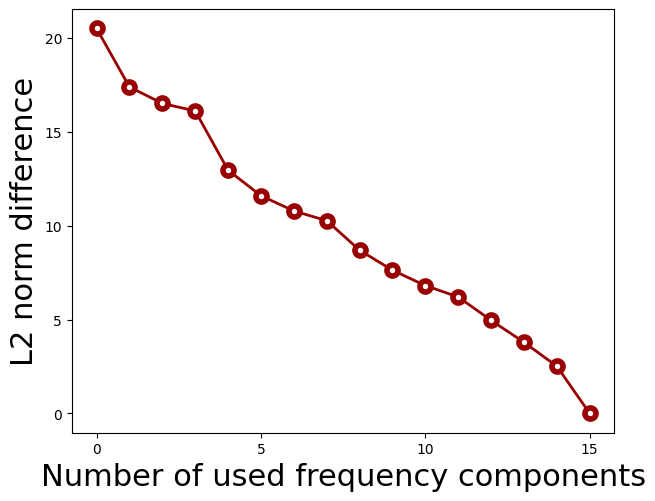

In [5]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_drop_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, l2_norm_drop_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("Number of used frequency components", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('l2norm_under_various_freq_comp.pdf', bbox_inches="tight", transparent=True) 

plt.show()

# Duplicate low frequency components

In [6]:
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(test_img_path)
overall_img_duplicate_freq_list = []
block_size = 4 
total_block_num = block_size * block_size
bs, ch, h, w = test_image_tensor.shape
base_freq_cutoff_list = [i for i in range(1,total_block_num+1,1)]
for base_freq_cutoff in base_freq_cutoff_list:
    test_inverse_transformed_img = test_img_dct_transform_duplicate_freq_reorder(test_image_tensor, bs, ch, h, w, base_freq_cutoff)
    transforms.functional.to_pil_image(test_inverse_transformed_img.squeeze(0)).save(f'reconstruct_dct_idct_image_duplicate_freq_{base_freq_cutoff}.png')
    overall_img_duplicate_freq_list.append(test_inverse_transformed_img)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [7]:
# Calculate l2 norm between original and each different frequency components
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(test_img_path)
l2_norm_duplicate_freq_difference_list = []
for img in overall_img_duplicate_freq_list:
    l2_norm_duplicate_freq_difference_list.append(torch.norm(torch.subtract(img, test_image_tensor)))

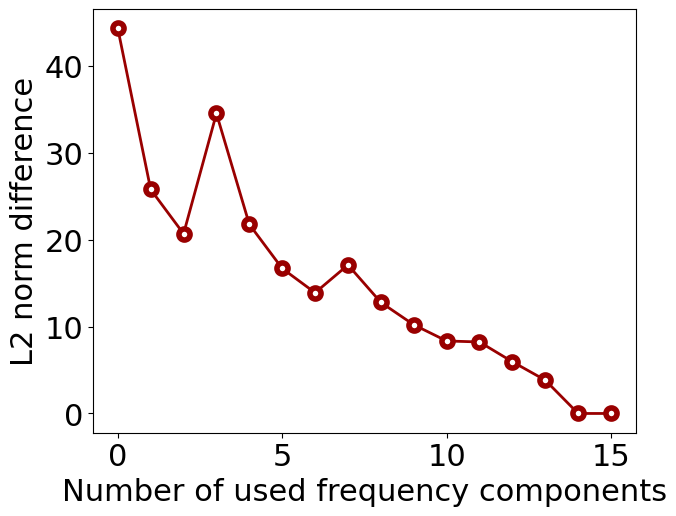

In [8]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_duplicate_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, l2_norm_duplicate_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("Number of used frequency components", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('l2norm_duplicated_freq_comp.pdf', bbox_inches="tight", transparent=True) 

plt.show()

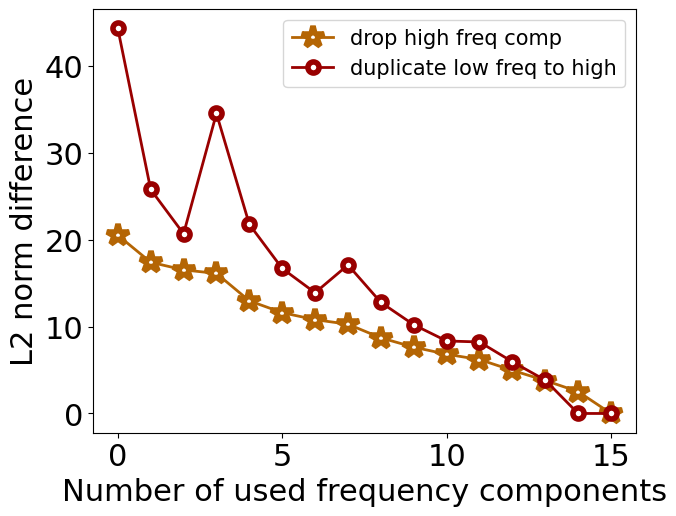

In [9]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_duplicate_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt_handler = []
plt_handler.append(plt.plot(x, l2_norm_drop_freq_difference_list, marker="*", markerfacecolor="#ffffff", color="#B46504", markersize=16, linewidth=2, markeredgewidth=4)[0])
plt_handler.append(plt.plot(x, l2_norm_duplicate_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)[0])

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("Number of used frequency components", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.legend(plt_handler, [r"drop high freq comp", r"duplicate low freq to high"], loc='best', ncol=1, fontsize=15)

plt.savefig('l2norm_undervarious_freq_drop_duplicate_comp.pdf', bbox_inches="tight", transparent=True) 

plt.show()

# Drop low frequency components

In [2]:
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(test_img_path)
overall_img_drop_low_freq_list = []
block_size = 4 
total_block_num = block_size * block_size
bs, ch, h, w = test_image_tensor.shape
base_freq_cutoff_list = [i for i in range(1, total_block_num+1, 1)]
for base_freq_cutoff in base_freq_cutoff_list:
    test_inverse_transformed_img = test_img_dct_transform_drop_low_freq_reorder(test_image_tensor, bs, ch, h, w, base_freq_cutoff)
    transforms.functional.to_pil_image(test_inverse_transformed_img.squeeze(0)).save(f'reconstruct_dct_idct_image_drop_low_freq_{base_freq_cutoff}.png')
    overall_img_drop_low_freq_list.append(test_inverse_transformed_img)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [3]:
# Calculate l2 norm between original and each different frequency components
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(test_img_path)
l2_norm_drop_freq_difference_list = []
for img in overall_img_drop_low_freq_list:
    l2_norm_drop_freq_difference_list.append(torch.norm(torch.subtract(img, test_image_tensor)))

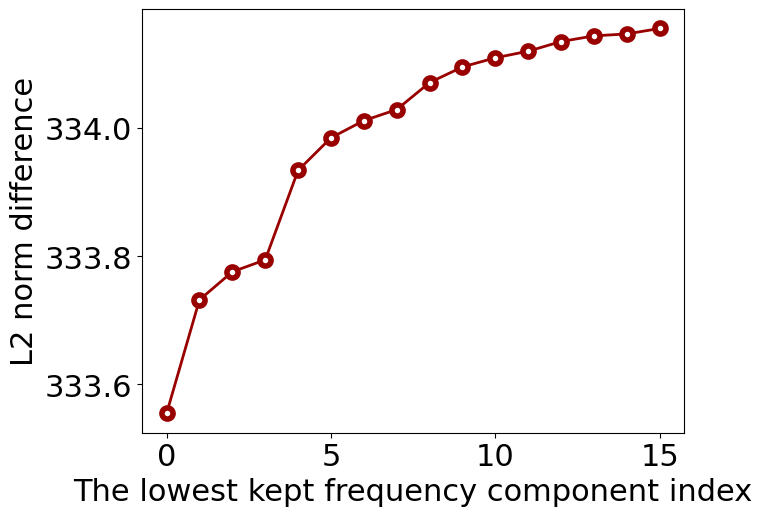

In [5]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_drop_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, l2_norm_drop_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("The lowest kept frequency component index", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('l2norm_under_various_freq_comp_drop_lower.pdf', bbox_inches="tight", transparent=True) 

plt.show()